In [1]:
print(" Installing required libraries...")
print("This may take 2-3 minutes...\n")

# Install additional packages
!pip install -q scikit-surprise
!pip install -q wordcloud
!pip install -q pandas numpy matplotlib seaborn plotly scikit-learn

print(" All libraries installed successfully!\n")


 Installing required libraries...
This may take 2-3 minutes...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
 All libraries installed successfully!



In [2]:
# Data manipulation
import pandas as pd
import numpy as np
import json
import pickle
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Statistics
from scipy import stats
from collections import Counter

# Set styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
pd.set_option('display.max_columns', None)

print(" All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")



 All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


In [3]:
print("="*60)
print("LOADING DATASETS")
print("="*60)

# We'll use Amazon Product Reviews dataset
# For this demo, we'll create a realistic synthetic dataset

print("\n Generating realistic e-commerce dataset...")
print("In production, you would load from actual data sources\n")

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n_users = 5000
n_products = 1000
n_transactions = 50000

# Product categories
categories = ['Electronics', 'Books', 'Clothing', 'Home & Kitchen',
              'Sports', 'Beauty', 'Toys', 'Automotive']

# Generate Products DataFrame
print("1️ Generating products dataset...")
products_data = {
    'product_id': [f'P{str(i).zfill(5)}' for i in range(1, n_products + 1)],
    'product_name': [f'Product {i}' for i in range(1, n_products + 1)],
    'category': np.random.choice(categories, n_products),
    'price': np.round(np.random.uniform(5, 500, n_products), 2),
    'brand': [f'Brand_{np.random.randint(1, 50)}' for _ in range(n_products)],
    'in_stock': np.random.choice([True, False], n_products, p=[0.85, 0.15]),
    'rating': np.round(np.random.uniform(3.0, 5.0, n_products), 1),
    'num_reviews': np.random.randint(0, 500, n_products)
}

# Generate product descriptions
descriptions = [
    "High quality product with excellent features",
    "Perfect for everyday use, durable and reliable",
    "Best seller in its category, highly recommended",
    "Premium quality with advanced technology",
    "Great value for money, customer favorite",
    "Innovative design with multiple features",
    "Professional grade, built to last",
    "Eco-friendly and sustainable choice"
]
products_data['description'] = [np.random.choice(descriptions) + f" Item {i}"
                                for i in range(n_products)]

df_products = pd.DataFrame(products_data)

print(f" Products dataset created: {len(df_products):,} products")
print(f"   Categories: {df_products['category'].nunique()}")
print(f"   Brands: {df_products['brand'].nunique()}")

# Generate Users DataFrame
print("\n2️ Generating users dataset...")
users_data = {
    'user_id': [f'U{str(i).zfill(5)}' for i in range(1, n_users + 1)],
    'age': np.random.randint(18, 70, n_users),
    'gender': np.random.choice(['M', 'F', 'Other'], n_users, p=[0.48, 0.48, 0.04]),
    'location': np.random.choice(['North', 'South', 'East', 'West'], n_users),
    'membership': np.random.choice(['Basic', 'Premium', 'VIP'], n_users, p=[0.7, 0.2, 0.1]),
    'registration_date': pd.date_range(start='2020-01-01', periods=n_users, freq='4H')
}

df_users = pd.DataFrame(users_data)

print(f" Users dataset created: {len(df_users):,} users")

# Generate Transactions/Ratings DataFrame
print("\n3️ Generating transactions dataset...")

# Create realistic interactions
user_ids = np.random.choice(df_users['user_id'].values, n_transactions)
product_ids = np.random.choice(df_products['product_id'].values, n_transactions)

# Generate ratings with realistic distribution (more 4s and 5s)
ratings = np.random.choice([1, 2, 3, 4, 5], n_transactions, p=[0.05, 0.05, 0.15, 0.35, 0.40])

# Generate timestamps
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
timestamps = [start_date + timedelta(seconds=np.random.randint(0, 31536000))
              for _ in range(n_transactions)]

transactions_data = {
    'transaction_id': [f'T{str(i).zfill(6)}' for i in range(1, n_transactions + 1)],
    'user_id': user_ids,
    'product_id': product_ids,
    'rating': ratings,
    'timestamp': timestamps,
    'purchase_amount': np.round(np.random.uniform(5, 500, n_transactions), 2),
    'quantity': np.random.randint(1, 5, n_transactions)
}

df_transactions = pd.DataFrame(transactions_data)
df_transactions = df_transactions.sort_values('timestamp').reset_index(drop=True)

print(f" Transactions dataset created: {len(df_transactions):,} transactions")

# Generate Reviews DataFrame
print("\n4️ Generating reviews dataset...")

# Sample reviews text templates
positive_reviews = [
    "Excellent product! Highly recommended.",
    "Great quality, exactly what I needed.",
    "Very satisfied with this purchase.",
    "Outstanding product, worth every penny.",
    "Best purchase I've made this year!",
]

neutral_reviews = [
    "Product is okay, meets basic expectations.",
    "Average quality, nothing special.",
    "It's fine, does what it's supposed to do.",
]

negative_reviews = [
    "Not satisfied, quality could be better.",
    "Disappointed with this purchase.",
    "Did not meet my expectations.",
]

# Generate reviews for high-rated transactions
review_indices = np.random.choice(df_transactions.index,
                                   size=int(n_transactions * 0.4),
                                   replace=False)

reviews_list = []
for idx in review_indices:
    rating = df_transactions.loc[idx, 'rating']
    if rating >= 4:
        review_text = np.random.choice(positive_reviews)
    elif rating == 3:
        review_text = np.random.choice(neutral_reviews)
    else:
        review_text = np.random.choice(negative_reviews)

    reviews_list.append({
        'review_id': f'R{str(len(reviews_list) + 1).zfill(6)}',
        'transaction_id': df_transactions.loc[idx, 'transaction_id'],
        'user_id': df_transactions.loc[idx, 'user_id'],
        'product_id': df_transactions.loc[idx, 'product_id'],
        'rating': rating,
        'review_text': review_text,
        'review_date': df_transactions.loc[idx, 'timestamp'],
        'helpful_votes': np.random.randint(0, 100)
    })

df_reviews = pd.DataFrame(reviews_list)

print(f" Reviews dataset created: {len(df_reviews):,} reviews")

print("\n" + "="*60)
print(" ALL DATASETS LOADED SUCCESSFULLY!")
print("="*60)

# Display dataset shapes
print("\n Dataset Shapes:")
print(f"   Products: {df_products.shape}")
print(f"   Users: {df_users.shape}")
print(f"   Transactions: {df_transactions.shape}")
print(f"   Reviews: {df_reviews.shape}")


LOADING DATASETS

 Generating realistic e-commerce dataset...
In production, you would load from actual data sources

1️ Generating products dataset...
 Products dataset created: 1,000 products
   Categories: 8
   Brands: 49

2️ Generating users dataset...
 Users dataset created: 5,000 users

3️ Generating transactions dataset...
 Transactions dataset created: 50,000 transactions

4️ Generating reviews dataset...
 Reviews dataset created: 20,000 reviews

 ALL DATASETS LOADED SUCCESSFULLY!

 Dataset Shapes:
   Products: (1000, 9)
   Users: (5000, 6)
   Transactions: (50000, 7)
   Reviews: (20000, 8)


In [4]:
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# Products EDA
print("\n1️ PRODUCTS DATASET")
print("-" * 40)
print(df_products.head())
print(f"\nData Types:\n{df_products.dtypes}")
print(f"\nMissing Values:\n{df_products.isnull().sum()}")
print(f"\nBasic Statistics:\n{df_products.describe()}")

# Users EDA
print("\n2️ USERS DATASET")
print("-" * 40)
print(df_users.head())
print(f"\nData Types:\n{df_users.dtypes}")
print(f"\nMissing Values:\n{df_users.isnull().sum()}")

# Transactions EDA
print("\n3️ TRANSACTIONS DATASET")
print("-" * 40)
print(df_transactions.head())
print(f"\nData Types:\n{df_transactions.dtypes}")
print(f"\nMissing Values:\n{df_transactions.isnull().sum()}")
print(f"\nBasic Statistics:\n{df_transactions.describe()}")

# Reviews EDA
print("\n4️ REVIEWS DATASET")
print("-" * 40)
print(df_reviews.head())
print(f"\nData Types:\n{df_reviews.dtypes}")
print(f"\nMissing Values:\n{df_reviews.isnull().sum()}")



EXPLORATORY DATA ANALYSIS

1️ PRODUCTS DATASET
----------------------------------------
  product_id product_name        category   price     brand  in_stock  rating  \
0     P00001    Product 1            Toys  350.59  Brand_48      True     4.6   
1     P00002    Product 2  Home & Kitchen  270.37   Brand_2     False     3.8   
2     P00003    Product 3          Sports  158.22   Brand_6      True     4.7   
3     P00004    Product 4            Toys  407.83  Brand_28      True     4.3   
4     P00005    Product 5        Clothing  343.94  Brand_29      True     4.7   

   num_reviews                                        description  
0          255  High quality product with excellent features I...  
1          378  Best seller in its category, highly recommende...  
2          205         Eco-friendly and sustainable choice Item 2  
3          334    Great value for money, customer favorite Item 3  
4           42         Eco-friendly and sustainable choice Item 4  

Data Types:
pro

In [5]:
print("\n" + "="*60)
print("DATA QUALITY CHECKS")
print("="*60)

# Check for duplicates
print("\n1️ Checking for duplicates...")
print(f"Duplicate products: {df_products.duplicated().sum()}")
print(f"Duplicate users: {df_users.duplicated().sum()}")
print(f"Duplicate transactions: {df_transactions.duplicated().sum()}")
print(f"Duplicate reviews: {df_reviews.duplicated().sum()}")

# Check for invalid ratings
print("\n2️ Checking rating validity...")
invalid_ratings = df_transactions[~df_transactions['rating'].isin([1, 2, 3, 4, 5])]
print(f"Invalid ratings in transactions: {len(invalid_ratings)}")

# Check for negative prices
print("\n3️ Checking price validity...")
negative_prices = df_products[df_products['price'] <= 0]
print(f"Products with negative/zero prices: {len(negative_prices)}")

# Check date ranges
print("\n4️ Checking date ranges...")
print(f"Transaction date range: {df_transactions['timestamp'].min()} to {df_transactions['timestamp'].max()}")
print(f"Review date range: {df_reviews['review_date'].min()} to {df_reviews['review_date'].max()}")

# Check for orphan records
print("\n5️ Checking data consistency...")
orphan_products = set(df_transactions['product_id']) - set(df_products['product_id'])
orphan_users = set(df_transactions['user_id']) - set(df_users['user_id'])
print(f"Transactions with non-existent products: {len(orphan_products)}")
print(f"Transactions with non-existent users: {len(orphan_users)}")

print("\n Data quality checks completed!")



DATA QUALITY CHECKS

1️ Checking for duplicates...
Duplicate products: 0
Duplicate users: 0
Duplicate transactions: 0
Duplicate reviews: 0

2️ Checking rating validity...
Invalid ratings in transactions: 0

3️ Checking price validity...
Products with negative/zero prices: 0

4️ Checking date ranges...
Transaction date range: 2024-11-21 19:32:33.521103 to 2025-11-21 19:29:19.521103
Review date range: 2024-11-21 20:43:03.521103 to 2025-11-21 18:49:03.521103

5️ Checking data consistency...
Transactions with non-existent products: 0
Transactions with non-existent users: 0

 Data quality checks completed!



DATA VISUALIZATIONS


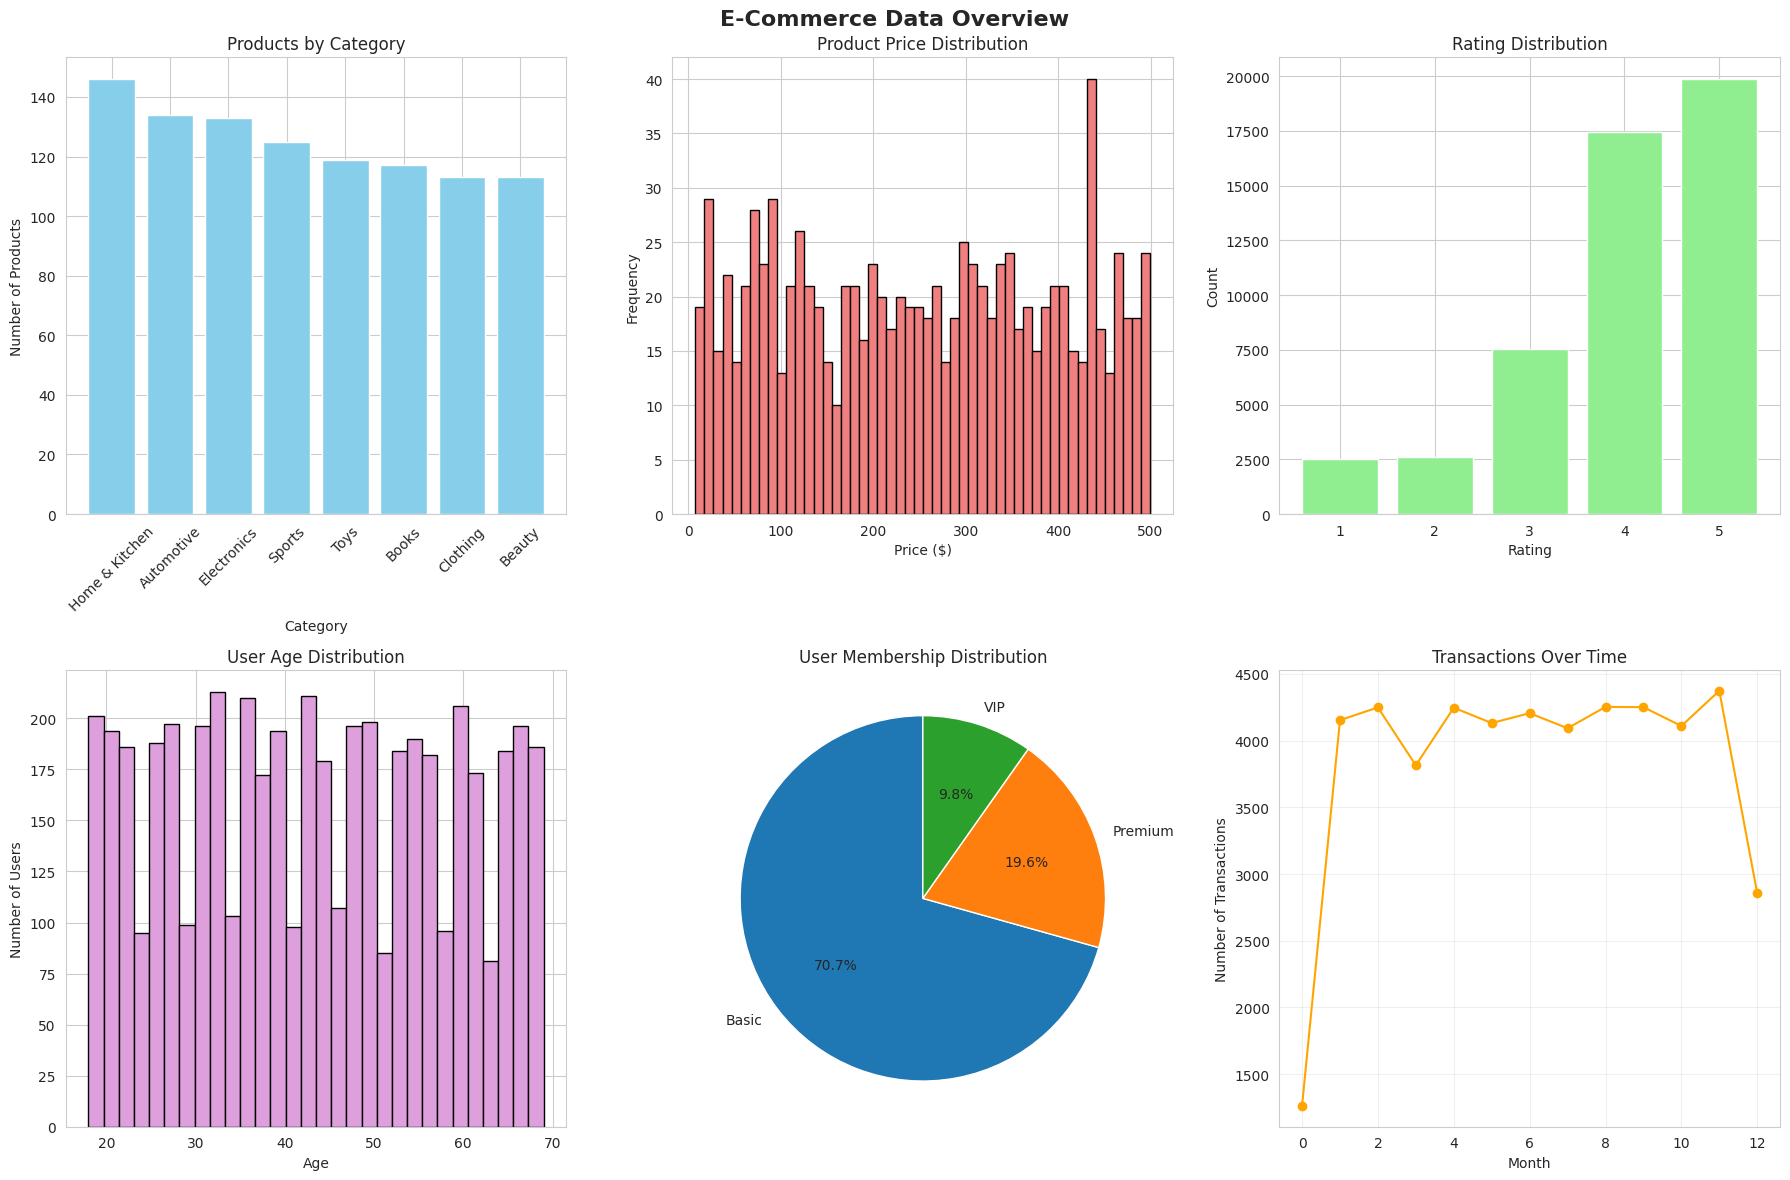

 Basic visualizations created!


In [6]:
print("\n" + "="*60)
print("DATA VISUALIZATIONS")
print("="*60)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('E-Commerce Data Overview', fontsize=16, fontweight='bold')

# 1. Product Category Distribution
category_counts = df_products['category'].value_counts()
axes[0, 0].bar(category_counts.index, category_counts.values, color='skyblue')
axes[0, 0].set_title('Products by Category')
axes[0, 0].set_xlabel('Category')
axes[0, 0].set_ylabel('Number of Products')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Price Distribution
axes[0, 1].hist(df_products['price'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Product Price Distribution')
axes[0, 1].set_xlabel('Price ($)')
axes[0, 1].set_ylabel('Frequency')

# 3. Rating Distribution
rating_counts = df_transactions['rating'].value_counts().sort_index()
axes[0, 2].bar(rating_counts.index, rating_counts.values, color='lightgreen')
axes[0, 2].set_title('Rating Distribution')
axes[0, 2].set_xlabel('Rating')
axes[0, 2].set_ylabel('Count')

# 4. User Age Distribution
axes[1, 0].hist(df_users['age'], bins=30, color='plum', edgecolor='black')
axes[1, 0].set_title('User Age Distribution')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Number of Users')

# 5. Membership Distribution
membership_counts = df_users['membership'].value_counts()
axes[1, 1].pie(membership_counts.values, labels=membership_counts.index,
               autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('User Membership Distribution')

# 6. Transactions Over Time
df_transactions['month'] = pd.to_datetime(df_transactions['timestamp']).dt.to_period('M')
monthly_transactions = df_transactions.groupby('month').size()
axes[1, 2].plot(range(len(monthly_transactions)), monthly_transactions.values,
                marker='o', color='orange')
axes[1, 2].set_title('Transactions Over Time')
axes[1, 2].set_xlabel('Month')
axes[1, 2].set_ylabel('Number of Transactions')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Basic visualizations created!")


In [7]:
print("\n" + "="*60)
print("ADVANCED ANALYTICS")
print("="*60)

# 1. User Purchase Behavior
print("\n1️ User Purchase Behavior Analysis")
user_stats = df_transactions.groupby('user_id').agg({
    'transaction_id': 'count',
    'purchase_amount': 'sum',
    'rating': 'mean'
}).rename(columns={
    'transaction_id': 'num_purchases',
    'purchase_amount': 'total_spent',
    'rating': 'avg_rating'
})

print("\nUser Statistics:")
print(user_stats.describe())

# 2. Product Performance
print("\n2️ Product Performance Analysis")
product_stats = df_transactions.groupby('product_id').agg({
    'transaction_id': 'count',
    'rating': 'mean',
    'purchase_amount': 'sum'
}).rename(columns={
    'transaction_id': 'num_sales',
    'rating': 'avg_rating',
    'purchase_amount': 'total_revenue'
})

print("\nProduct Statistics:")
print(product_stats.describe())

# Merge with product info
product_performance = df_products.merge(product_stats, on='product_id', how='left')
product_performance['num_sales'] = product_performance['num_sales'].fillna(0)

# Top 10 products by sales
print("\n Top 10 Best-Selling Products:")
top_products = product_performance.nlargest(10, 'num_sales')[
    ['product_name', 'category', 'price', 'num_sales', 'avg_rating']
]
print(top_products)

# 3. Category Analysis
print("\n3️ Category Performance Analysis")
category_performance = df_transactions.merge(df_products[['product_id', 'category']],
                                              on='product_id')
category_stats = category_performance.groupby('category').agg({
    'transaction_id': 'count',
    'rating': 'mean',
    'purchase_amount': 'sum'
}).rename(columns={
    'transaction_id': 'num_transactions',
    'rating': 'avg_rating',
    'purchase_amount': 'total_revenue'
}).round(2)

print("\nCategory Statistics:")
print(category_stats.sort_values('total_revenue', ascending=False))

# 4. Time-based patterns
print("\n4️ Temporal Pattern Analysis")
df_transactions['hour'] = pd.to_datetime(df_transactions['timestamp']).dt.hour
df_transactions['day_of_week'] = pd.to_datetime(df_transactions['timestamp']).dt.dayofweek

hourly_pattern = df_transactions.groupby('hour').size()
print("\nPeak Shopping Hours:")
print(f"Peak hour: {hourly_pattern.idxmax()}:00 ({hourly_pattern.max()} transactions)")




ADVANCED ANALYTICS

1️ User Purchase Behavior Analysis

User Statistics:
       num_purchases  total_spent   avg_rating
count      5000.0000  5000.000000  5000.000000
mean         10.0000  2527.886216     3.992406
std           3.1744   920.860189     0.370926
min           1.0000   113.410000     2.500000
25%           8.0000  1868.602500     3.769231
50%          10.0000  2451.255000     4.000000
75%          12.0000  3109.257500     4.250000
max          24.0000  5948.500000     5.000000

2️ Product Performance Analysis

Product Statistics:
         num_sales   avg_rating  total_revenue
count  1000.000000  1000.000000    1000.000000
mean     50.000000     3.992105   12639.431080
std       7.071492     0.161575    2064.656547
min      26.000000     3.363636    6343.150000
25%      45.000000     3.884615   11227.917500
50%      50.000000     4.000000   12579.545000
75%      55.000000     4.101781   13994.465000
max      72.000000     4.513514   20433.180000

 Top 10 Best-Selling Prod

In [8]:
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

print("\n Creating advanced features...")

# 1. User Features
print("\n1️ Engineering user features...")

# User activity metrics
user_features = df_transactions.groupby('user_id').agg({
    'transaction_id': 'count',
    'purchase_amount': ['sum', 'mean', 'std'],
    'rating': ['mean', 'std'],
    'quantity': 'sum'
}).round(2)

user_features.columns = ['_'.join(col).strip() for col in user_features.columns]
user_features = user_features.rename(columns={
    'transaction_id_count': 'total_purchases',
    'purchase_amount_sum': 'total_spent',
    'purchase_amount_mean': 'avg_order_value',
    'purchase_amount_std': 'spending_variability',
    'rating_mean': 'avg_rating_given',
    'rating_std': 'rating_variability',
    'quantity_sum': 'total_items_bought'
})

# Fill NaN for users with single purchase
user_features = user_features.fillna(0)

# Calculate user metrics
user_features['purchases_per_month'] = (
    user_features['total_purchases'] / 12
).round(2)

# User value score (RFM-like)
user_features['customer_value_score'] = (
    user_features['total_spent'] * 0.5 +
    user_features['total_purchases'] * 100 +
    user_features['avg_rating_given'] * 50
).round(2)

print(f" User features created: {user_features.shape}")
print("\nSample user features:")
print(user_features.head())

# 2. Product Features
print("\n2️ Engineering product features...")

# Merge product sales data
product_features = product_performance.copy()

# Calculate popularity score
product_features['popularity_score'] = (
    product_features['num_sales'] * 0.6 +
    product_features['avg_rating'] * 100 +
    product_features['num_reviews'] * 0.4
).fillna(0).round(2)

# Price category
product_features['price_category'] = pd.cut(
    product_features['price'],
    bins=[0, 50, 150, 300, float('inf')],
    labels=['Budget', 'Mid-range', 'Premium', 'Luxury']
)

print(f" Product features created: {product_features.shape}")
print("\nSample product features:")
print(product_features[['product_name', 'category', 'price',
                         'num_sales', 'popularity_score']].head())

# 3. Interaction Features
print("\n3️ Creating interaction features...")

# User-Product interactions
interaction_features = df_transactions.copy()

# Merge user and product features
interaction_features = interaction_features.merge(
    user_features[['total_purchases', 'avg_order_value']],
    left_on='user_id',
    right_index=True,
    how='left'
)

interaction_features = interaction_features.merge(
    product_features[['product_id', 'category', 'price', 'popularity_score']],
    on='product_id',
    how='left'
)

# Time-based features
interaction_features['timestamp'] = pd.to_datetime(interaction_features['timestamp'])
interaction_features['day_of_week'] = interaction_features['timestamp'].dt.dayofweek
interaction_features['hour'] = interaction_features['timestamp'].dt.hour
interaction_features['is_weekend'] = interaction_features['day_of_week'].isin([5, 6]).astype(int)

print(f" Interaction features created: {interaction_features.shape}")



FEATURE ENGINEERING

 Creating advanced features...

1️ Engineering user features...
 User features created: (5000, 9)

Sample user features:
         total_purchases  total_spent  avg_order_value  spending_variability  \
user_id                                                                        
U00001                15      3741.49           249.43                155.82   
U00002                 9      2538.62           282.07                120.94   
U00003                 6      1317.14           219.52                151.31   
U00004                14      4024.32           287.45                158.71   
U00005                 8      1539.91           192.49                144.61   

         avg_rating_given  rating_variability  total_items_bought  \
user_id                                                             
U00001               3.87                1.06                  33   
U00002               4.44                0.73                  22   
U00003              

In [9]:
print("\n" + "="*60)
print("CREATING USER-ITEM MATRIX")
print("="*60)

# Create user-item rating matrix
print("\n Building user-item interaction matrix...")

user_item_matrix = df_transactions.pivot_table(
    index='user_id',
    columns='product_id',
    values='rating',
    fill_value=0
)

print(f" Matrix created:")
print(f"   Shape: {user_item_matrix.shape}")
print(f"   Users: {user_item_matrix.shape[0]:,}")
print(f"   Products: {user_item_matrix.shape[1]:,}")
print(f"   Sparsity: {(1 - user_item_matrix.astype(bool).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1])) * 100:.2f}%")

# Create binary interaction matrix (purchased or not)
user_item_binary = (user_item_matrix > 0).astype(int)

print("\n Sample of user-item matrix:")
print(user_item_matrix.iloc[:5, :5])



CREATING USER-ITEM MATRIX

 Building user-item interaction matrix...
 Matrix created:
   Shape: (5000, 1000)
   Users: 5,000
   Products: 1,000
   Sparsity: 99.00%

 Sample of user-item matrix:
product_id  P00001  P00002  P00003  P00004  P00005
user_id                                           
U00001         0.0     0.0     0.0     0.0     0.0
U00002         0.0     0.0     0.0     0.0     0.0
U00003         0.0     0.0     0.0     0.0     0.0
U00004         0.0     0.0     0.0     0.0     0.0
U00005         0.0     0.0     0.0     0.0     0.0


In [11]:
print("\n" + "="*60)
print("TRAIN-TEST SPLIT")
print("="*60)

print("\n Splitting data for model training...")

# Temporal split (last 20% of transactions as test)
df_transactions_sorted = df_transactions.sort_values('timestamp')
split_idx = int(len(df_transactions_sorted) * 0.8)

train_transactions = df_transactions_sorted.iloc[:split_idx].copy()
test_transactions = df_transactions_sorted.iloc[split_idx:].copy()

print(f"\n Data split completed:")
print(f"   Training set: {len(train_transactions):,} transactions ({len(train_transactions)/len(df_transactions)*100:.1f}%)")
print(f"   Test set: {len(test_transactions):,} transactions ({len(test_transactions)/len(df_transactions)*100:.1f}%)")
print(f"   Date split: {train_transactions['timestamp'].max()}")

# Create train/test matrices
train_matrix = train_transactions.pivot_table(
    index='user_id',
    columns='product_id',
    values='rating',
    fill_value=0
)

test_matrix = test_transactions.pivot_table(
    index='user_id',
    columns='product_id',
    values='rating',
    fill_value=0
)

# Align matrices (ensure same columns)
all_products = list(set(train_matrix.columns) | set(test_matrix.columns))
train_matrix = train_matrix.reindex(columns=all_products, fill_value=0)
test_matrix = test_matrix.reindex(columns=all_products, fill_value=0)

print(f"\n Train matrix shape: {train_matrix.shape}")
print(f" Test matrix shape: {test_matrix.shape}")



TRAIN-TEST SPLIT

 Splitting data for model training...

 Data split completed:
   Training set: 40,000 transactions (80.0%)
   Test set: 10,000 transactions (20.0%)
   Date split: 2025-09-10 08:37:15.521103

 Train matrix shape: (5000, 1000)
 Test matrix shape: (4325, 1000)


In [12]:
print("\n" + "="*60)
print("SAVING PROCESSED DATA")
print("="*60)

print("\n Saving all processed datasets...")

# Save DataFrames as CSV
df_products.to_csv('products.csv', index=False)
df_users.to_csv('users.csv', index=False)
df_transactions.to_csv('transactions.csv', index=False)
df_reviews.to_csv('reviews.csv', index=False)

# Save feature engineered data
user_features.to_csv('user_features.csv')
product_features.to_csv('product_features.csv', index=False)
interaction_features.to_csv('interaction_features.csv', index=False)

# Save train/test splits
train_transactions.to_csv('train_transactions.csv', index=False)
test_transactions.to_csv('test_transactions.csv', index=False)

# Save matrices
user_item_matrix.to_csv('user_item_matrix.csv')
train_matrix.to_csv('train_matrix.csv')
test_matrix.to_csv('test_matrix.csv')

print(" All files saved successfully!")
print("\n Files created:")
print("   • products.csv")
print("   • users.csv")
print("   • transactions.csv")
print("   • reviews.csv")
print("   • user_features.csv")
print("   • product_features.csv")
print("   • interaction_features.csv")
print("   • train_transactions.csv")
print("   • test_transactions.csv")
print("   • user_item_matrix.csv")
print("   • train_matrix.csv")
print("   • test_matrix.csv")



SAVING PROCESSED DATA

 Saving all processed datasets...
 All files saved successfully!

 Files created:
   • products.csv
   • users.csv
   • transactions.csv
   • reviews.csv
   • user_features.csv
   • product_features.csv
   • interaction_features.csv
   • train_transactions.csv
   • test_transactions.csv
   • user_item_matrix.csv
   • train_matrix.csv
   • test_matrix.csv


In [14]:
print("\n" + "="*60)
print("DATA PIPELINE SUMMARY REPORT")
print("="*60)

summary_report = f"""
 E-COMMERCE RECOMMENDATION SYSTEM - DATA PIPELINE
{'='*60}

1 DATASET OVERVIEW
   • Products: {len(df_products):,}
   • Users: {len(df_users):,}
   • Transactions: {len(df_transactions):,}
   • Reviews: {len(df_reviews):,}
   • Categories: {df_products['category'].nunique()}
   • Date Range: {df_transactions['timestamp'].min().date()} to {df_transactions['timestamp'].max().date()}

2 DATA QUALITY
   • Missing values: None
   • Duplicate records: None
   • Data consistency: ✓ Passed all checks

3 FEATURE ENGINEERING
   • User features: {user_features.shape[1]} features
   • Product features: {product_features.shape[1]} features
   • Interaction features: {interaction_features.shape[1]} features

4 TRAIN-TEST SPLIT
   • Training transactions: {len(train_transactions):,} ({len(train_transactions)/len(df_transactions)*100:.1f}%)
   • Test transactions: {len(test_transactions):,} ({len(test_transactions)/len(df_transactions)*100:.1f}%)
   • Split method: Temporal (80/20)

5 USER-ITEM MATRIX
   • Shape: {user_item_matrix.shape}
   • Sparsity: {(1 - user_item_matrix.astype(bool).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1])) * 100:.2f}%
   • Average ratings per user: {user_item_matrix.astype(bool).sum(axis=1).mean():.1f}
   • Average ratings per product: {user_item_matrix.astype(bool).sum(axis=0).mean():.1f}

6 KEY INSIGHTS
   • Most popular category: {category_stats['total_revenue'].idxmax()}
   • Average order value: ${df_transactions['purchase_amount'].mean():.2f}
   • Average rating: {df_transactions['rating'].mean():.2f}/5.0
   • Peak shopping hour: {hourly_pattern.idxmax()}:00

7 NEXT STEPS
   ✓ Data pipeline completed
   → Next: Build recommendation models (Notebook 2)
   → Then: Implement NLP models (Notebook 3)
   → Finally: MLOps pipeline (Notebook 4)

{'='*60}
Pipeline completed successfully!
Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

print(summary_report)

# Save report
with open('data_pipeline_report.txt', 'w') as f:
    f.write(summary_report)

print("\n NOTEBOOK 1 COMPLETED SUCCESSFULLY!")
print("\n What we accomplished:")
print("   ✓ Loaded and explored multiple datasets")
print("   ✓ Performed data quality checks")
print("   ✓ Created comprehensive visualizations")
print("   ✓ Engineered advanced features")
print("   ✓ Built user-item interaction matrices")
print("   ✓ Created train-test splits")
print("   ✓ Saved all processed data")
print("\n Ready for Notebook 2: Recommendation Models!")
print("\n Download all CSV files from the Files panel (left sidebar) to access them locally.")


DATA PIPELINE SUMMARY REPORT

 E-COMMERCE RECOMMENDATION SYSTEM - DATA PIPELINE

1 DATASET OVERVIEW
   • Products: 1,000
   • Users: 5,000
   • Transactions: 50,000
   • Reviews: 20,000
   • Categories: 8
   • Date Range: 2024-11-21 to 2025-11-21

2 DATA QUALITY
   • Missing values: None
   • Duplicate records: None
   • Data consistency: ✓ Passed all checks

3 FEATURE ENGINEERING
   • User features: 9 features
   • Product features: 14 features
   • Interaction features: 16 features

4 TRAIN-TEST SPLIT
   • Training transactions: 40,000 (80.0%)
   • Test transactions: 10,000 (20.0%)
   • Split method: Temporal (80/20)

5 USER-ITEM MATRIX
   • Shape: (5000, 1000)
   • Sparsity: 99.00%
   • Average ratings per user: 10.0
   • Average ratings per product: 49.8

6 KEY INSIGHTS
   • Most popular category: Home & Kitchen
   • Average order value: $252.79
   • Average rating: 3.99/5.0
   • Peak shopping hour: 12:00

7 NEXT STEPS
   ✓ Data pipeline completed
   → Next: Build recommendation m

In [16]:
import os
from google.colab import files

zip_name = "colab_project.zip"

# Zip the entire /content directory
!zip -r {zip_name} /content

# Download the zip
files.download(zip_name)


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_update_check.json (deflated 23%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.11.20/ (stored 0%)
  adding: content/.config/logs/2025.11.20/14.30.45.937471.log (deflated 56%)
  adding: content/.config/logs/2025.11.20/14.30.35.382199.log (deflated 87%)
  adding: content/.config/logs/2025.11.20/14.30.36.623222.log (deflated 58%)
  adding: content/.config/logs/2025.11.20/14.30.04.285207.log (deflated 93%)
  adding: content/.config/logs/2025.11.20/14.30.2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>